In [1]:
%%html
<style>
.text_cell {
    font-family: "Vazir", "Segoe UI";
}
.rendered_html p {
    text-align: right;
}
.text_cell {
    direction: rtl;
}
div.input {
    flex-direction: row-reverse;
}
</style>

# هوش مصنوعی - پروژهٔ جایگزین امتحان
## حسین سلطانلو - ۸۱۰۱۹۵۴۰۷

در اولین قدم اقدام به import کردن کتاب‌خانه‌های موردنیاز می‌کنیم:

In [2]:
from __future__ import unicode_literals
import re
from hazm import Normalizer, sent_tokenize, Stemmer, Lemmatizer
import string
import nltk
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

سپس داده‌ها را از فایل مربوطه می‌خوانیم و برای تسهیل در استفاده‌های بعدی کمی تغییرات در چینش ستون‌های آن ایجاد می‌کنیم.

In [3]:
data = pd.read_csv('mobile_phone_dataset.csv')
data.drop(data.columns[[0]], axis=1, inplace=True)
data = data[['brand', 'city', 'title', 'desc', 'created_at', 'price', 'image_count']]

این مرحله مختص به متناسب‌سازی داده‌های categorical است. بسیاری از مدل‌های یادگیری ماشین فقط با داده‌های عددی سر و کار دارند و باید به نحوی این‌گونه داده‌های categorical را به داده‌های عددی تبدیل کنیم. برای این کار روش‌های متنوعی وجود دارد که در این‌جا از روش One Hot Encoding استفاده می‌کنیم.  One Hot Encoding به هر دسته یک ستون اختصاص می‌دهد و هر سطری که جزو آن دسته باشد را با 1 نمایش می‌دهد. ایراد استفاده از این روش این است که منجر به افزایش بسیار زیاد تعداد featureها و هم‌چنین بزرگ‌شدن جدول داده‌ها می‌شود.
دلیل استفاده از این روش به جای Label Encoding این است که نمی‌خواهیم به دسته‌ها ارزش عددی بدهیم تا دسته‌ای به دیگری برتری پیدا نکند.

In [4]:
onehotencoder = OneHotEncoder(handle_unknown='ignore')
feature_arr = onehotencoder.fit_transform(data[['brand','city']]).toarray()
feature_labels = onehotencoder.categories_
feature_labels = np.array(feature_labels).ravel()
features = pd.DataFrame(feature_arr, columns=feature_labels)
data = data.join(features)

In [5]:
data.head(5)

,brand,city,title,desc,created_at,price,image_count,Apple::اپل,HTC::اچ‌تی‌سی,Huawei::هوآوی,...,ZTE::زدتی‌ای,Ahvaz,Isfahan,Karaj,Kermanshah,Mashhad,Qom,Shiraz,Tabriz,Tehran
0,Nokia::نوکیا,Qom,نوکیا6303,سلام.یه گوشیه6303سالم که فقط دوتا خط کوچیک رو ...,Wednesday 07AM,60000,2,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,Apple::اپل,Tehran,ایفون ٥اس٣٢گیگ,درحد نو سالم اصلى بدون ضربه مهلت تست میدم,Wednesday 11AM,1150000,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,Samsung::سامسونگ,Mashhad,سامسونگ j5,گوشى بسیار بسیار تمیز و فقط سه هفته کارکرده و ...,Wednesday 02PM,590000,2,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,Apple::اپل,Karaj,گرى 5s ایفون 32گیگ,گلس پشت و رو .کارت اپل ای دی. لوازم جانبی اصلی...,Wednesday 04PM,1100000,3,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Samsung::سامسونگ,Tehran,galaxy S5 Gold در حد آک,کاملا تمیز و بدون حتی 1 خط و خش\nبه همراه گلاس...,Friday 01PM,900000,2,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [6]:
mi = mutual_info_regression(data.iloc[:, 6:], data['price'])

In [7]:
column_names = data.columns[6:]

در این بخش با محاسبه‌ی Information Gain می‌خواهیم ببینیم که کدام ستون‌ها بیشترین یا کم‌ترین اثر را بر یادگیری دارند. البته باید به این نکته اشاره کرد که در این بخش فقط دسته‌هایی که انکود شده‌اند و هم‌چنین ستون تعداد تصاویر وارد این مقایسه شده‌اند؛ چون داده‌های متنی در این بخش قابل استفاده نیستند. هم‌چنین با کمی تفکر می‌توان به این نتیجه رسید که روز و ساعت هفته نمی‌تواند اثری بر قیمت ثبت‌شده‌ی یک آگهی داشته باشد. بنابراین از ستون created_at هیچ استفاده‌ای در روند این پروژه نشده است. با همین استدلال می‌توان ستون image_count را هم بی‌معنی خواند ولی به هر حال در نمودار زیر می‌بینیم که این ستون می‌تواند مقدار خیلی کمی اثرگذار باشد.

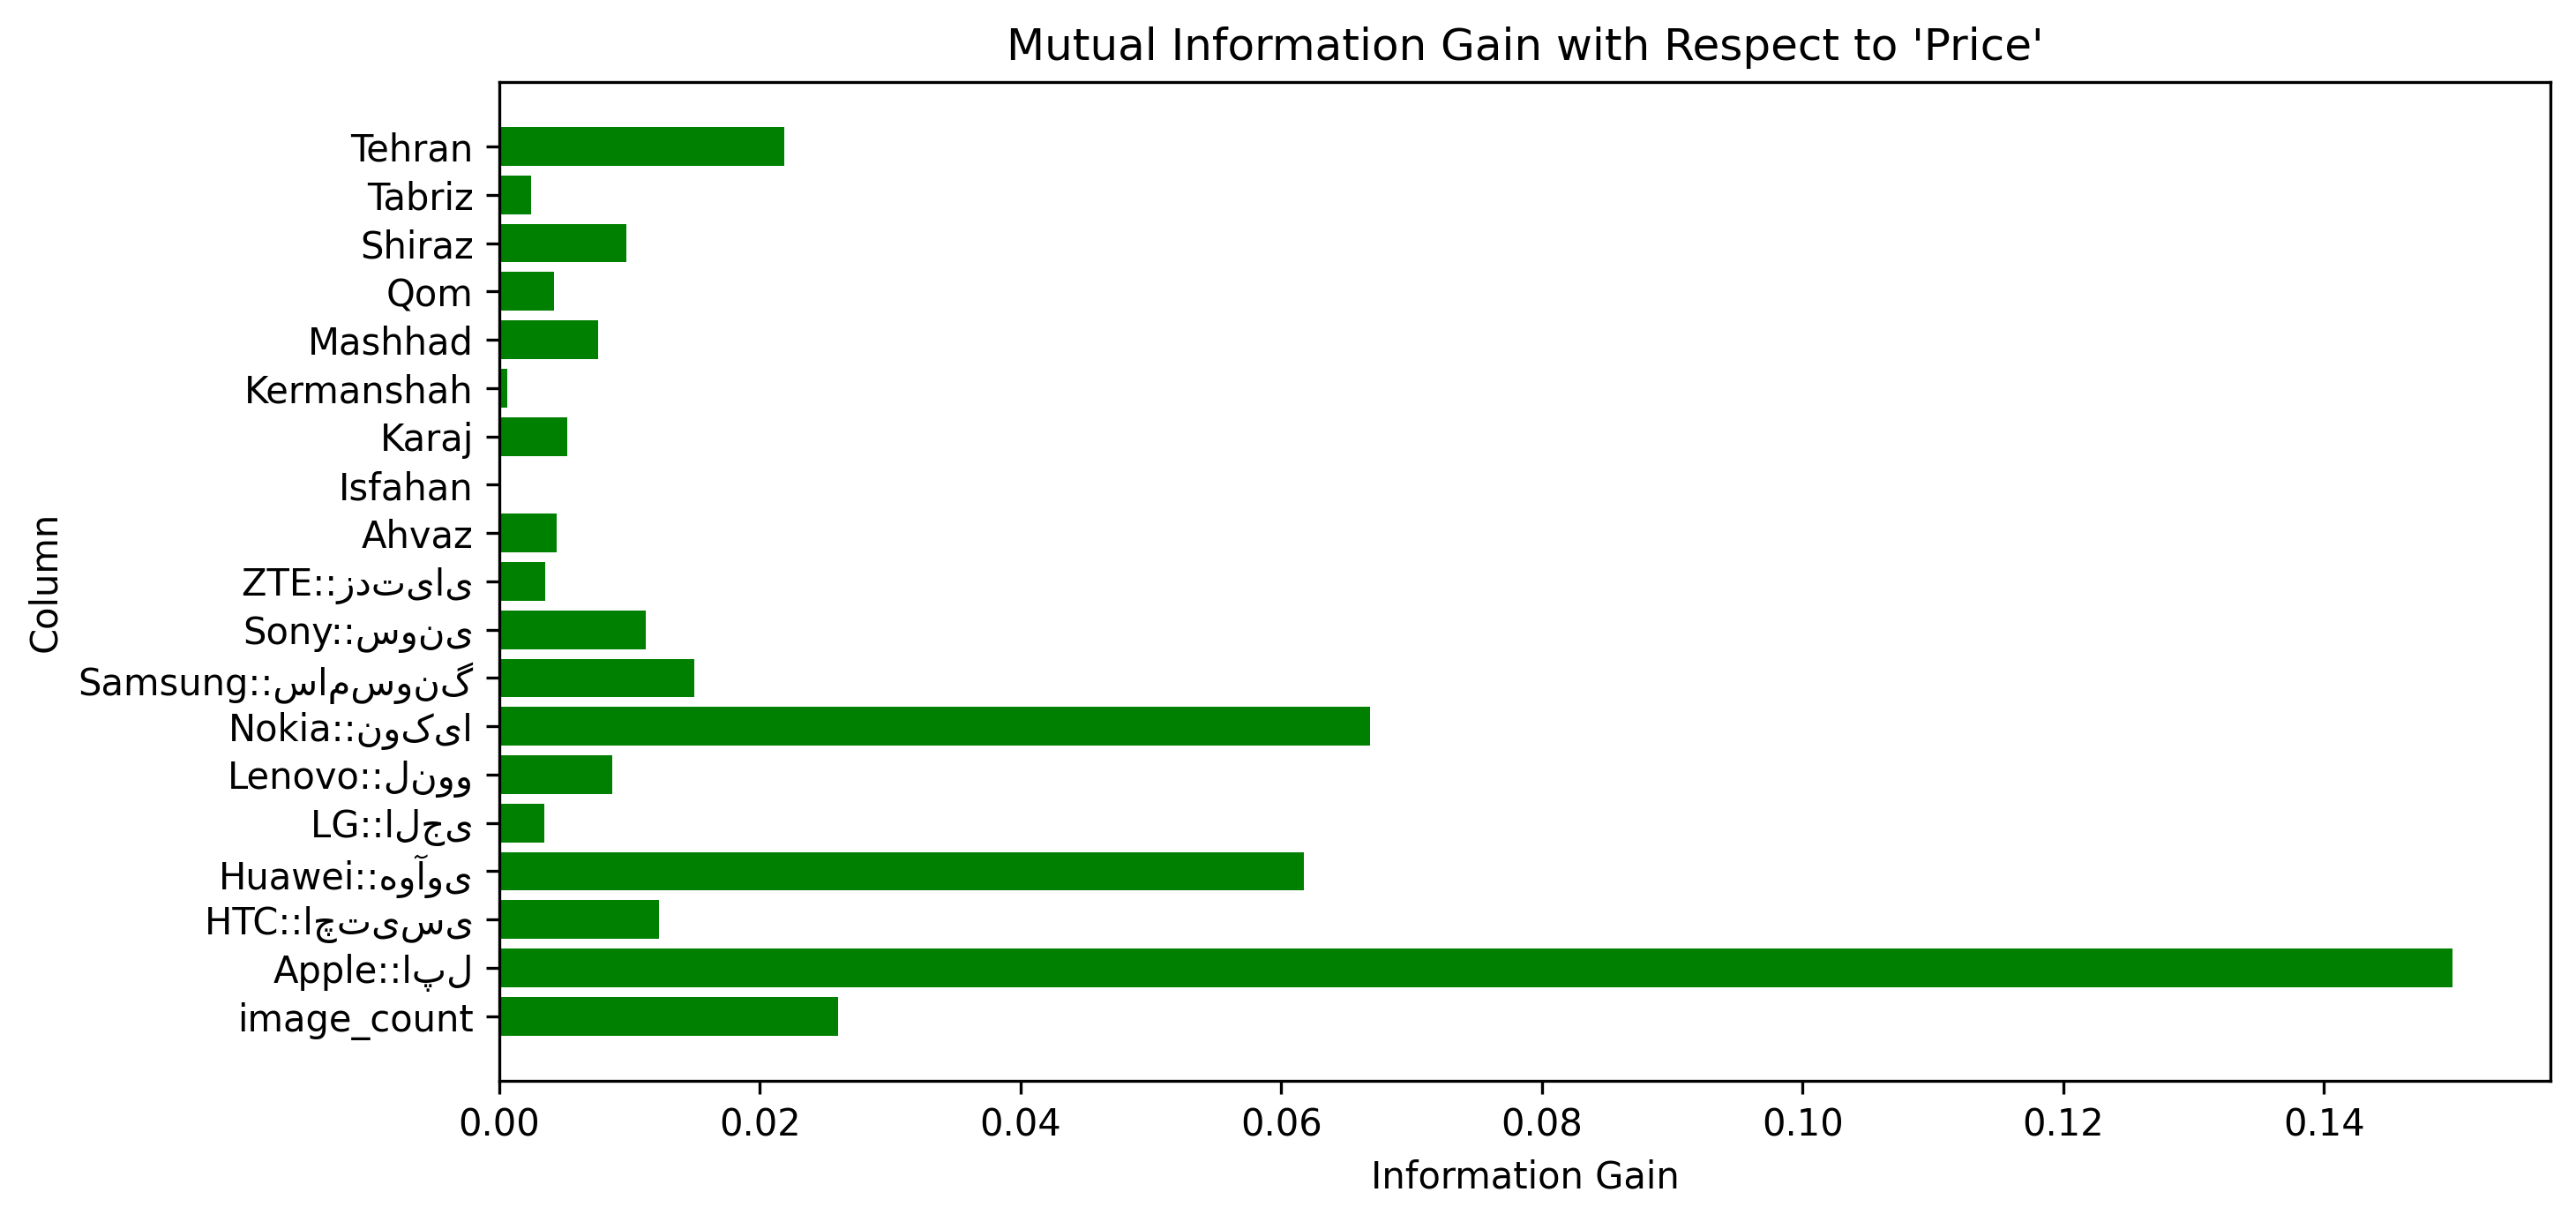

In [8]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 5), dpi=300, facecolor='w', edgecolor='k')
plt.barh(range(len(column_names)), mi, color='green')
plt.ylabel("Column")
plt.xlabel("Information Gain")
plt.title("Mutual Information Gain with Respect to 'Price'")
plt.yticks(range(len(column_names)), column_names)
plt.show()

در این قسمت از یک scaler بهره می‌گیریم تا با استفاده از آن داده‌ها را scale کنیم. علت انجام این کار این است که ارزش عددی را از داده‌ها سلب کنیم و در مدلی مانند K Nearest Neighbors که بر مبنای فاصله‌های عددی کار می‌کند، تمامی featureها در یک مقیاس باشند تا از وزن‌دهی ناخواسته به آن‌ها براثر عدم تطابق مقیاس‌ها جلوگیری شود و هر feature مشارکتی برابر با بقیه در محاسبه‌ی فواصل داشته باشد.

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

data['image_count'] = scaler.fit_transform(data['image_count'].values.reshape(-1, 1))

In [10]:
data.head(5)

,brand,city,title,desc,created_at,price,image_count,Apple::اپل,HTC::اچ‌تی‌سی,Huawei::هوآوی,...,ZTE::زدتی‌ای,Ahvaz,Isfahan,Karaj,Kermanshah,Mashhad,Qom,Shiraz,Tabriz,Tehran
0,Nokia::نوکیا,Qom,نوکیا6303,سلام.یه گوشیه6303سالم که فقط دوتا خط کوچیک رو ...,Wednesday 07AM,60000,0.26035,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,Apple::اپل,Tehran,ایفون ٥اس٣٢گیگ,درحد نو سالم اصلى بدون ضربه مهلت تست میدم,Wednesday 11AM,1150000,-1.19809,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,Samsung::سامسونگ,Mashhad,سامسونگ j5,گوشى بسیار بسیار تمیز و فقط سه هفته کارکرده و ...,Wednesday 02PM,590000,0.26035,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,Apple::اپل,Karaj,گرى 5s ایفون 32گیگ,گلس پشت و رو .کارت اپل ای دی. لوازم جانبی اصلی...,Wednesday 04PM,1100000,0.98957,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Samsung::سامسونگ,Tehran,galaxy S5 Gold در حد آک,کاملا تمیز و بدون حتی 1 خط و خش\nبه همراه گلاس...,Friday 01PM,900000,0.26035,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


در این مرحله اقدام به پیش‌پردازش داده‌های متنی می‌کنیم. کارهایی که در این بخش انجام می‌شوند به شرح زیر هستند:
- تبدیل حروف بزرگ به حروف کوچک
- حذف فواصل اضافی
- تبدیل اعداد فارسی به انگلیسی
- حذف نشانه‌ها
- حذف واژگان توقف (stop words)
- استفاده از stemmer برای پیداکردن ریشه‌ی کلمات

این مراحل بر روی دو ستون title و desc انجام می‌شوند تا در مراحل بعدی بتوانیم بهتر از آن‌ها استفاده کنیم.

In [11]:
def _multiple_replace(mapping, text):
    pattern = "|".join(map(re.escape, mapping.keys()))
    return re.sub(pattern, lambda m: mapping[m.group()], str(text))

def convert_fa_numbers(input_str):
    """
    This function convert Persian numbers to English numbers.
    
    Keyword arguments:
    input_str -- It should be string
    Returns: English numbers
    """
    mapping = {
        '۰': '0',
        '۱': '1',
        '۲': '2',
        '۳': '3',
        '۴': '4',
        '۵': '5',
        '۶': '6',
        '۷': '7',
        '۸': '8',
        '۹': '9',
        '.': '.',
        '١': '1',
        '٢': '2',
        '٣': '3',
        '٤': '4',
        '٥': '5',
        '٦': '6',
        '٧': '7',
        '٨': '8',
        '٩': '9',
        '٠': '0',
    }
    return _multiple_replace(mapping, input_str)

In [12]:
with open("persian", encoding = "utf-8") as f:
    stopwords = [line.rstrip() for line in f]
stopwords = set(stopwords)

def preprocess(text):
    new_text = str(text).lower()
    new_text = convert_fa_numbers(new_text)
    new_text = new_text.strip()
    for ch in string.punctuation:
        new_text = new_text.replace(ch, " ")
    new_text = ' '.join(new_text.split())
    nt = [w for w in new_text.split() if w not in stopwords]
    stemmer = Stemmer()
    stemmed_nt = [stemmer.stem(w) for w in nt]
    
    return ' '.join([w for w in nt if len(w) > 1])

data['desc'] = data['desc'].apply(preprocess)
data['title'] = data['title'].apply(preprocess)

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59189 entries, 0 to 59188
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   brand             59189 non-null  object 
 1   city              59189 non-null  object 
 2   title             59189 non-null  object 
 3   desc              59189 non-null  object 
 4   created_at        59189 non-null  object 
 5   price             59189 non-null  int64  
 6   image_count       59189 non-null  float64
 7   Apple::اپل        59189 non-null  float64
 8   HTC::اچ‌تی‌سی     59189 non-null  float64
 9   Huawei::هوآوی     59189 non-null  float64
 10  LG::ال‌جی         59189 non-null  float64
 11  Lenovo::لنوو      59189 non-null  float64
 12  Nokia::نوکیا      59189 non-null  float64
 13  Samsung::سامسونگ  59189 non-null  float64
 14  Sony::سونی        59189 non-null  float64
 15  ZTE::زدتی‌ای      59189 non-null  float64
 16  Ahvaz             59189 non-null  float6

In [14]:
data[['title', 'desc']].head(20)

,title,desc
0,نوکیا6303,سلام گوشیه6303سالم دوتا خط کوچیک ال سی دیشه شا...
1,ایفون 5اس32گیگ,درحد نو سالم اصلى ضربه مهلت تست میدم
2,سامسونگ j5,گوشى تمیز سه هفته کارکرده حد آک
3,گرى 5s ایفون 32گیگ,گلس کارت اپل دی لوازم جانبی اصلی معاوضه اندروی...
4,galaxy s5 gold حد آک,تمیز خط خش همراه گلاس قاب محافظ
5,8800 sirocco,تمیز لوازم گوشی اصل المان شارژر ایستاده،هندزفو...
6,معاوضه نوکیا 215 مودم 4g usb,فروش گوشی طرح نوکیا 215 گوشی طرح زرد رنگ دوسیم...
7,پریم گرند سالم,تعمیر نرفته
8,ایفون 64,ایفون تمیز لحاظ سالم
9,گوشی هواوی y625,گوشیو ضربه نخورده وبه شرت میدم


In [15]:
# data['english'] = data['desc'].apply(lambda text : (" ".join(re.findall("([a-zA-Z][a-zA-Z0-9_@]+|[0-9_@][a-zA-Z0-9_@]*[a-zA-Z])", text))).split()) + data['title'].apply(lambda text : (" ".join(re.findall("([a-zA-Z][a-zA-Z0-9_@]+|[0-9_@][a-zA-Z0-9_@]*[a-zA-Z])", text))).split())
# data['english'] = data['english'].apply(lambda l : list(set(l)))
# data['english'] = data['english'].apply(lambda w : [s.lower() for s in w])

در این قسمت اقدام به جداسازی آگهی‌هایی می‌کنیم که قیمت برای آن‌ها ثبت نشده است تا بتوانیم باقی آگهی‌ها را به دسته‌های آموزش و آزمون تقسیم کنیم.

In [16]:
seen_data = data[data['price'] != -1]
seen_data = seen_data.copy()
unseen_data = data[data['price'] == -1]
unseen_data = unseen_data.copy()

از آن‌جا که تعداد واژگان مورداستفاده در این مجموعه‌ی داده زیاد است، نیاز داریم که تنها واژگانی را نگه داریم که استفاده‌ی آن‌ها کم‌تر از یک حدی نیست تا بدین شکل واژگانی که اثر خاصی بر یادگیری ندارند یا حذف کنیم. در این‌جا واژگانی که استفاده‌ی آن‌ها بیش از ۵۰ بار است را برگزیده‌ایم.

In [17]:
from collections import defaultdict
count = defaultdict(int)

for index, row in seen_data.iterrows():
    words = row['title'].split() + row['desc'].split()
    for w in words:
        count[w] = count[w] + 1
words_count = [(k, v) for k, v in count.items() if v > 50]
words_count.sort(key=lambda tup: tup[1], reverse = True)
top_words = [k for k, v in words_count]

In [18]:
print(top_words[:30])

['گوشی', 'سالم', 'تمیز', 'سامسونگ', 'خط', 'نو', 'خش', 'حد', 'معاوضه', 'گیگ', 'رنگ', 'دوربین', 'اس', 'فروش', 'قیمت', 'داره', 'موبایل', 'تخفیف', 'تماس', 'سلام', '16', 'ایفون', 'همراه', 'سیم', 'شارژر', 'میدم', 'قاب', 'حافظه', 'اصلی', 'گلس']


In [19]:
len(top_words)

1312

In [20]:
top_english_words = []
for w in top_words:
    if re.match("([a-zA-Z][a-zA-Z0-9_@]+|[0-9_@][a-zA-Z0-9_@]*[a-zA-Z])", w):
        top_english_words.append(w)

In [21]:
print(top_english_words[:30])

['iphone', '5s', '4g', '6s', 'lla', 'htc', 'num', 'gold', 'samsung', 'galaxy', 's6', '16g', 'lg', '3g', '4s', 'gray', 'sony', 'j7', 'apple', 's5', 'huawei', 'edge', 's4', 'a5', 's7', 'j5', 's3', 'plus', '64g', '32g']


In [22]:
len(top_english_words)

201

توابعی را جهت تسهیل در محاسبه و نمایش متریک‌های سنجش دقت مدل تعریف می‌کنیم:

In [28]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
def calc_metrics(y_act, y_pred):
    return int(mean_absolute_error(y_act, y_pred)), int(mean_squared_error(y_act, y_pred)), int(mean_squared_error(y_act, y_pred, squared=False))

def show_metrics(y_test, y_train, test_pred, train_pred):
    mae, mse, rmse = calc_metrics(y_test, test_pred)
    print("---------------------TEST DATA---------------------")
    print("Mean Absolute Error:     ", f'{mae:,}')
    print("Mean Squared Error:      ", f'{mse:,}')
    print("Root Mean Squared Error: ", f'{rmse:,}')
    mae, mse, rmse = calc_metrics(y_train, train_pred)
    print("---------------------TRAIN DATA--------------------")
    print("Mean Absolute Error:     ", f'{mae:,}')
    print("Mean Squared Error:      ", f'{mse:,}')
    print("Root Mean Squared Error: ", f'{rmse:,}')
    print("---------------------------------------------------")

برای سنجش دقت از چند مدل مثل LinearRegression، KNeighborsRegressor و RandomForestRegressor استفاده می‌کنیم و سپس نتایج آن‌ها را با هم مقایسه می‌کنیم:

In [29]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [30]:

X = seen_data.iloc[:, 6:]
y = seen_data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.3)

regressor = LinearRegression(normalize=True)
regressor.fit(X_train, y_train)

LinearRegression(normalize=True)

In [31]:
test_pred = regressor.predict(X_test)
train_pred = regressor.predict(X_train)

وقتی با استفاده از ستون‌های مربوط به شهر، برند و تعداد تصاویر از LinearRegression استفاده می‌کنیم، RMSE معادل ۴۴۶هزار تومان را به‌دست می‌آوریم. این رگرسور ساده‌ترین نوع رگرسور است. در مراحل بعدی دیگر مدل‌ها را نیز امتحان می‌کنیم تا برای افزایش دقت تلاش کنیم.

دلیل عدم استفاده از متون این است که اگر بخواهیم از کلمات هم استفاده کنیم، تعداد featureها بسیار زیاد می‌شود و در نتیجه احتمال اورفیتینگ بالا می‌رود. لذا فعلاً تنها از ستون‌های گفته‌شده استفاده می‌کنیم. در ادامه از رفش TF-IDF برای استخراج feature از متون استفاده خواهیم کرد تا عملکرد آن را با حالت فعلی مقایسه کنیم.

In [32]:
show_metrics(y_test, y_train, test_pred, train_pred)

---------------------TEST DATA---------------------
Mean Absolute Error:      337,522
Mean Squared Error:       199,130,124,367
Root Mean Squared Error:  446,239
---------------------TRAIN DATA--------------------
Mean Absolute Error:      338,121
Mean Squared Error:       198,655,420,422
Root Mean Squared Error:  445,707
---------------------------------------------------


در این بخش از KNeighborsRegressor استفاده می‌کنیم و برای تعداد همسایه‌های متفاوت دقت آن را می‌سنجیم. طبق نمودار مشاهده می‌شود که کم‌ترین میزان خطای آن، تفاوتی با LinearRegression ندارد.

In [33]:
test_rmse=[]
train_rmse=[]
for n in range(1, 1000, 50):
    regressor = KNeighborsRegressor(n_neighbors=n)
    regressor.fit(X_train, y_train)
    test_pred = regressor.predict(X_test)
    train_pred = regressor.predict(X_train)
    mae, mse, rmse = calc_metrics(y_test, test_pred)
    test_rmse.append(rmse)
    mae, mse, rmse = calc_metrics(y_train, train_pred)
    train_rmse.append(rmse)

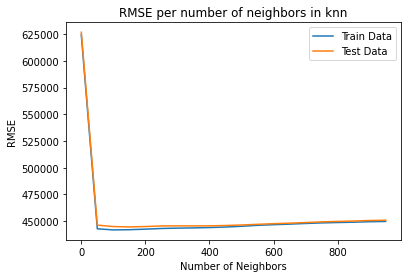

In [34]:
plt.plot(range(0, 1000, 50), train_rmse, label='Train Data')
plt.plot(range(0, 1000, 50), test_rmse, label='Test Data')
plt.xlabel('Number of Neighbors')
plt.ylabel('RMSE')
plt.title('RMSE per number of neighbors in knn')
plt.legend()
plt.show()

استفاده از RandomForestRegressor نیز تغییری در میزان خطای RMSE ایجاد نکرده است. از این موارد درمی‌یابیم که تغییر مدل با فیچرهایی که انتخاب کرده‌ایم چندان کارساز نیست. در نتیجه در بخش بعد از فیچرهای دیگری استفاده می‌کنیم. 

In [35]:
regressor = RandomForestRegressor()
regressor.fit(X_train, y_train)
test_pred = regressor.predict(X_test)
train_pred = regressor.predict(X_train)
show_metrics(y_test, y_train, test_pred, train_pred)

---------------------TEST DATA---------------------
Mean Absolute Error:      334,272
Mean Squared Error:       197,093,933,556
Root Mean Squared Error:  443,952
---------------------TRAIN DATA--------------------
Mean Absolute Error:      330,579
Mean Squared Error:       192,716,319,623
Root Mean Squared Error:  438,994
---------------------------------------------------


In [36]:
test_rmse=[]
train_rmse=[]
for n in [1, 5, 10, 50, 100]:
    regressor = RandomForestRegressor(max_depth=n)
    regressor.fit(X_train, y_train)
    test_pred = regressor.predict(X_test)
    train_pred = regressor.predict(X_train)
    mae, mse, rmse = calc_metrics(y_test, test_pred)
    test_rmse.append(rmse)
    mae, mse, rmse = calc_metrics(y_train, train_pred)
    train_rmse.append(rmse)

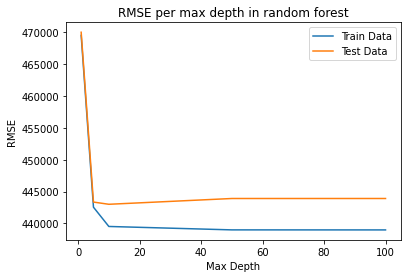

In [37]:
plt.plot([1, 5, 10, 50, 100], train_rmse, label='Train Data')
plt.plot([1, 5, 10, 50, 100], test_rmse, label='Test Data')
plt.xlabel('Max Depth')
plt.ylabel('RMSE')
plt.title('RMSE per max depth in random forest')
plt.legend()
plt.show()

در این قسمت اقدام به استفاده از ستون‌های متنی desc و title و استخراج فیچر از آن‌ها می‌کنیم. به این منظور با استفاده از تعداد تکرارهای کلماتی که قبلا به‌دست آورده بودیم، کلماتی که کم‌تر کاربرد داشته‌اند را حذف می‌کنیم تا باعث تسهیل در یادگیری شویم.

روش استخراج فیچر از متون نیز روش TF-IDF است. در این روش ابتدا فرکانس تکرار هر کلمه در هر متن محاسبه می‌شود و سپس در معکوس تکرار کلمه در کل متون ضرب می‌شود. با این روش می‌توانیم به ازای هر کلمه در هر متن، میزان مرتبط بودن آن کلمه و متن را محاسبه کنیم و در واقع کلمات کلیدی متن را شناسایی کنیم که بسیار کمک‌کننده خواهد بود. حال فیچرهایی داریم که عددی هستند و از متون استخراج شده‌اند و می‌توانیم آن‌ها را به مدل‌های مختلف بدهیم و میزان دقتشان را بسنجیم.

In [38]:
data['title'] = data['title'].apply(lambda t : ' '.join([w for w in t.split() if w in top_words]))
data['desc'] = data['desc'].apply(lambda t : ' '.join([w for w in t.split() if w in top_words]))
seen_data['title'] = seen_data['title'].apply(lambda t : ' '.join([w for w in t.split() if w in top_words]))
seen_data['desc'] = seen_data['desc'].apply(lambda t : ' '.join([w for w in t.split() if w in top_words]))
data['text'] = data['title'] + ' ' + data['desc']
seen_data['text'] = seen_data['title'] + ' ' + seen_data['desc'] + ' ' + seen_data['brand'] + ' ' + seen_data['city']
X = seen_data['text']
y = seen_data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.3)

حال داده‌های خروجی TF-IDF را در LinearRegression استفاده می‌کنیم و شاهد کاهش بسیار زیاد خطا هستیم. این نشان می‌دهد که فیچرهای جدید بسیار کارآمدتر هستند.

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer
regressor = Pipeline([('tfidf', TfidfVectorizer()), ('reg', LinearRegression()),])
regressor.fit(X_train, y_train)
test_pred = regressor.predict(X_test)
train_pred = regressor.predict(X_train)
show_metrics(y_test, y_train, test_pred, train_pred)

---------------------TEST DATA---------------------
Mean Absolute Error:      212,196
Mean Squared Error:       92,649,618,523
Root Mean Squared Error:  304,383
---------------------TRAIN DATA--------------------
Mean Absolute Error:      205,766
Mean Squared Error:       85,888,060,818
Root Mean Squared Error:  293,066
---------------------------------------------------


همین کار را برای KNeighborsRegressor تکرار می‌کنیم و مشاهده می‌کنیم که باز هم دقت بالا رفته است. گرچه در این حالت نسبت به LinearRegression خطا کمی بیشتر است اما در حالت کلی شاهد بهبود هستیم. این کار را برای مقادیر تعداد همسایه‌های مختلف نیز انجام می‌دهیم تا از بهینه‌بودن پاسخ اطمینان حاصل کنیم.

البته در این حالت شاهد پدیده‌ی overfitting هستیم که در بخش بعد تلاش می‌کنیم تا با تغییر تعداد همسایگان آن را از بین ببریم. تعداد پیش‌فرض همسایگان ۵ عدد است که همین باعث می‌شود مدل بسیار به داده‌های آموزشی وابسته شود و اورفیتینگ رخ دهد.

In [40]:
regressor = Pipeline([('tfidf', TfidfVectorizer()), ('reg', KNeighborsRegressor()),])
regressor.fit(X_train, y_train)
test_pred = regressor.predict(X_test)
train_pred = regressor.predict(X_train)
show_metrics(y_test, y_train, test_pred, train_pred)

---------------------TEST DATA---------------------
Mean Absolute Error:      211,485
Mean Squared Error:       107,752,807,183
Root Mean Squared Error:  328,257
---------------------TRAIN DATA--------------------
Mean Absolute Error:      172,719
Mean Squared Error:       70,968,691,644
Root Mean Squared Error:  266,399
---------------------------------------------------


In [41]:
test_rmse=[]
train_rmse=[]
for n in [1, 5, 10, 50, 100, 500]:
    regressor = Pipeline([('tfidf', TfidfVectorizer()), ('reg', KNeighborsRegressor(n_neighbors=n)),])
    regressor.fit(X_train, y_train)
    test_pred = regressor.predict(X_test)
    train_pred = regressor.predict(X_train)
    mae, mse, rmse = calc_metrics(y_test, test_pred)
    test_rmse.append(rmse)
    mae, mse, rmse = calc_metrics(y_train, train_pred)
    train_rmse.append(rmse)

طبق نمودار زیر با افزایش تعداد همسایگان، مشکل اورفیتینگ حل می‌شود اما هم‌چنان خطا بیشتر از حالت قبل است.

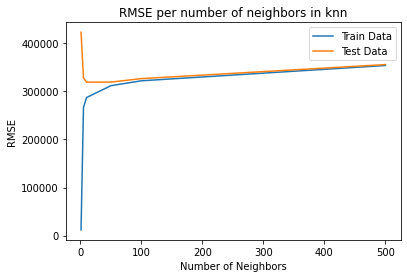

In [42]:
plt.plot([1, 5, 10, 50, 100, 500], train_rmse, label='Train Data')
plt.plot([1, 5, 10, 50, 100, 500], test_rmse, label='Test Data')
plt.xlabel('Number of Neighbors')
plt.ylabel('RMSE')
plt.title('RMSE per number of neighbors in knn')
plt.legend()
plt.show()

نهایتاً از RandomForestRegressor استفاده می‌کنیم ولی می‌بینیم که خطا کمی بیشتر از حالت‌های قبلی است که این می‌تواند به‌دلیل تعدد فیچرهای خروجی از TF-IDF باشد. 

In [43]:
regressor = Pipeline([('tfidf', TfidfVectorizer()), ('reg', RandomForestRegressor(max_depth=10)),])
regressor.fit(X_train, y_train)
test_pred = regressor.predict(X_test)
train_pred = regressor.predict(X_train)
show_metrics(y_test, y_train, test_pred, train_pred)

---------------------TEST DATA---------------------
Mean Absolute Error:      241,911
Mean Squared Error:       117,862,277,059
Root Mean Squared Error:  343,310
---------------------TRAIN DATA--------------------
Mean Absolute Error:      232,271
Mean Squared Error:       105,728,260,146
Root Mean Squared Error:  325,158
---------------------------------------------------


در پایان قیمت‌های واردنشده را با استفاده از مدل LinearRegression و استفاده از متد TF-IDF که کم‌ترین خطا را داشته پیش‌بینی می‌کنیم و در فایلی با نام out.csv ذخیره می‌کنیم. 

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer
regressor = Pipeline([('tfidf', TfidfVectorizer()), ('reg', LinearRegression()),])
regressor.fit(X_train, y_train)
test_pred = regressor.predict(X_test)
train_pred = regressor.predict(X_train)
show_metrics(y_test, y_train, test_pred, train_pred)

---------------------TEST DATA---------------------
Mean Absolute Error:      212,196
Mean Squared Error:       92,649,618,523
Root Mean Squared Error:  304,383
---------------------TRAIN DATA--------------------
Mean Absolute Error:      205,766
Mean Squared Error:       85,888,060,818
Root Mean Squared Error:  293,066
---------------------------------------------------


In [45]:
unseen_data['title'] = unseen_data['title'].apply(lambda t : ' '.join([w for w in t.split() if w in top_words]))
unseen_data['desc'] = unseen_data['desc'].apply(lambda t : ' '.join([w for w in t.split() if w in top_words]))
unseen_data['text'] = unseen_data['title'] + ' ' + unseen_data['desc'] + ' ' + unseen_data['brand'] + ' ' + unseen_data['city']
X_unseen = unseen_data['text']
predictions = regressor.predict(X_unseen)

In [52]:
unseen_data['price'] = predictions

In [53]:
unseen_data.head(5)

,Unnamed: 0,brand,city,title,desc,image_count,created_at,price
23,23,Samsung::سامسونگ,Karaj,A3 2015,گوشی در حده نو کلا 2 هفتس خریدمش.با تشکر از سا...,1,Tuesday 12PM,649944.393349
28,28,Apple::اپل,Qom,اپل 5s ٣٢ گیگ بسیار تمیز در حد,گوشی بسیار تمیز در حد قیمت مقطوع میباشد لطفا ت...,2,Saturday 04AM,875872.336302
32,32,Apple::اپل,Shiraz,اقساط٢٤ماهه بدون پیش پرداخت,اقساط ٢٤ماهه بدون پیش پرداخت,0,Sunday 03PM,635723.735156
36,37,Sony::سونی,Qom,سونی مدل acro s گوشی هواوی y300,"گوشی سونی مدل acro s دوربین 12 فیلمبرداری HD ,...",2,Thursday 06AM,56553.275691
44,46,HTC::اچ‌تی‌سی,Tehran,ّگوشی موبایل htc desire610 جهت معاوضه,معاوضه با ایفون 4\nگوشیم سالم سالم 4g\nبدون هی...,0,Monday 08PM,412181.516661


In [56]:
data = pd.read_csv('mobile_phone_dataset.csv')
data.drop(data.columns[[0]], axis=1, inplace=True)
unseen_data = data[data['price'] == -1]
unseen_data = unseen_data.copy()
unseen_data['price'] = predictions
unseen_data['price'] = unseen_data['price'].apply(lambda i: int(i))
unseen_data.to_csv('out.csv')

ایده‌هایی برای بهبود:

یکی از ایده‌ها این است که داده‌های مفیدتری را از متون استخراج کنیم. مثلاً به‌طور خاص تلاش بیشتری برای یافتن مدل دستگاه از روی متون بکنیم و یا این‌که صفات زبان فارسی و کلماتی که بخش‌های مختلف موبایل را توصیف می‌کنند از این متون استخراج کرده و به‌عنوان فیچر در نظر بگیریم.

از طرف دیگر می‌توانیم در مدل‌هایی که استفاده می‌شوند نیز تنوع بدهیم و مثلاً از شبکه‌های عصبی برای این کار استفاده کنیم که البته زمان‌بر است و در مدت زمان محدود این پروژه دسترسی به آن سخت بود. البته لزوما استفاده از مدل‌های دیگر نمی‌تواند باعث بهبود دقت شود و فاکتورهای متنوعی مثل فیچرهای انتخاب نیز در این موارد سهیم هستند.